In [1]:
import tensorflow as tf
import matplotlib.pyplot
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2

/Users/phaniram/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pickle
def PrepareTrainData():
    pickle_obj = pickle.load(file=open('face_all.pickle', 'rb'))
    features = pickle_obj['Features']
    labels = pickle_obj['Labels']
    labels = labels[0]
    labels = labels[0:21100]
    train_x = features[0:21100] / 255
    train_all_glasses = train_x[np.where(labels == 1)]
    train_all_no_glasses = train_x[np.where(labels == 0)]
    return train_all_glasses, train_all_no_glasses

In [47]:
celeb_glasses, celeb_no_glasses = PrepareTrainData()

In [60]:
tf.reset_default_graph()

In [61]:
def visualizeTransferLearning(index = 1000):
    fig,axes = plt.subplots(nrows = 10, ncols = 3, figsize=(50,50))
    for i in range(10):
        test = celebs_with_glasses[i+index]
        test = np.expand_dims(test,axis =0)
        fig.add_subplot()
        axes[i, 0].imshow(test.reshape(54,44), cmap='gray')
        axes[i, 1].imshow(ae_with_glasses.predict(test).reshape(54,44),cmap='gray')
        axes[i, 2].imshow(ae_no_glasses.predict(test).reshape(54,44),cmap='gray')  

In [62]:
class HiddenLayer(object):
    def __init__(self, M1, M2, layer_num, activation=tf.nn.leaky_relu):
        self.activation = activation
        layer_num = str(layer_num)
        self.layer_num = layer_num
        r= math.sqrt(6) / math.sqrt(M1 + M2 + 1)
        self.W1 = tf.Variable(tf.random_normal(shape =(M1, M2), stddev=r), name = 'W1'+layer_num)   
        self.b1 = tf.Variable(tf.random_normal(shape =(1, M2), stddev=r), name = 'b1'+ layer_num)
        self.W2 = tf.Variable(tf.random_normal(shape =(M2, M1), stddev=r), name = 'W2'+layer_num)
        self.b2 = tf.Variable(tf.random_normal(shape =(1, M1), stddev=r), name = 'b1'+ layer_num)
        self.params = [self.W1, self.W2]
                         
    def forward(self,X, encode = False, batch_norm = False): 
        if encode == True:
            l=tf.matmul(X, self.W1)+self.b1
            if batch_norm == True:
                ll = tf.nn.batch_normalization(l, mean = 0.5, variance = 0.02, offset=0, scale = 1, variance_epsilon=1e-5, name = 'encode'+ self.layer_num)
        else:
            l=tf.matmul(X, self.W2)+self.b2
            if batch_norm == True:
                ll = tf.nn.batch_normalization(l, mean = 0.5, variance = 0.02, offset=0, scale = 1, variance_epsilon=1e-5, name = 'decode'+ self.layer_num)
        return self.activation(l)
    
    def layer_weight(self, norm = tf.nn.l2_loss):
        return norm(self.W1) + norm(self.W2)

In [63]:
class CSE674AutoEncoder():
    def __init__(self, n_input, hidden_layer_sizes ,rho=0.01, alpha=0.0001, beta=3, activation=tf.nn.sigmoid, optimizer=tf.train.AdamOptimizer()):
        self.n_input=n_input # input size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.rho=rho  # sparse parameters
        self.alpha =alpha
        self.beta=beta
        self.optimizer=optimizer 
        self.X = tf.placeholder(tf.float32, shape =(None,n_input), name = 'X')
        self.encode_layers = []
        self.decode_layers = []
        self.layers_weights = []
        
        #now make the structure
        layer_num = 0
        M1 = n_input
        for M2 in hidden_layer_sizes:
            layer_num += 1
            layer = HiddenLayer(M1, M2 ,layer_num)
            M1 = M2
            self.encode_layers.append(layer)
            self.decode_layers.append(layer)
            
        output = self.X
        for layer in self.encode_layers:
            output = layer.forward(output, encode=True, batch_norm = False)
            layer_weight = layer.layer_weight()
            self.layers_weights += layer_weight
        
        self.Z = output
        for layer in reversed(self.decode_layers):
            output = layer.forward(output, batch_norm = False)
            self.layers_weights += layer_weight
            
        self.X_hat = output 
        self.loss = self.loss(self.X)
        self.train_op  = self.optimizer.minimize(self.loss)
        
        # always initialize global variables after optimizer
        self.init_op = tf.global_variables_initializer()
        self.session = tf.InteractiveSession()
        self.session.run(self.init_op)
            
    def kl_divergence(self, rho, rho_hat):
        #ρ: −ρlogh ̄j −(1−ρ)log(1−h ̄j)+constant
        return rho * tf.log(rho) - rho * tf.log(rho_hat) + (1 - rho) * tf.log(1 - rho) - (1 - rho) * tf.log(1 - rho_hat)
            
    def loss(self,X):
        H = self.Z
        rho_hat=tf.reduce_mean(H,axis=0)   #Average hidden layer over all data points in X, Page 14 in https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf
        kl=self.kl_divergence(self.rho, rho_hat)
        X_=self.X_hat
        diff=X-X_
        layers_weights_all= tf.reduce_sum(self.layers_weights, axis = 0)
        cost= 0.5*tf.reduce_mean(tf.reduce_sum(diff**2,axis=1)) 
        #+ 0.5*(layers_weights_all) + self.beta*tf.reduce_sum(kl) 
        return cost
    
    def train_each_batch(self, X):
        return self.session.run([self.loss, self.train_op], feed_dict ={self.X:X})
    
    def predict(self, X):
        return self.session.run(self.X_hat, feed_dict={self.X:X})
    
    def extract_Z(self, X):
        return self.session.run(self.Z, feed_dict= {self.X:X})
    
    def predict_using_Z(self, X, Z):
        self.Z = Z
        return self.session.run(self.X_hat, feed_dict= {self.X:X})    

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training celeb with glasses is done!
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training celeb without glasses is also done!
Training done!


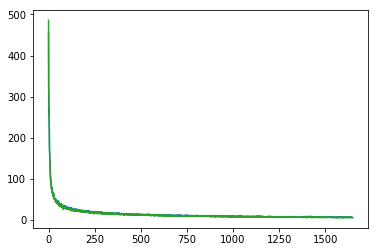

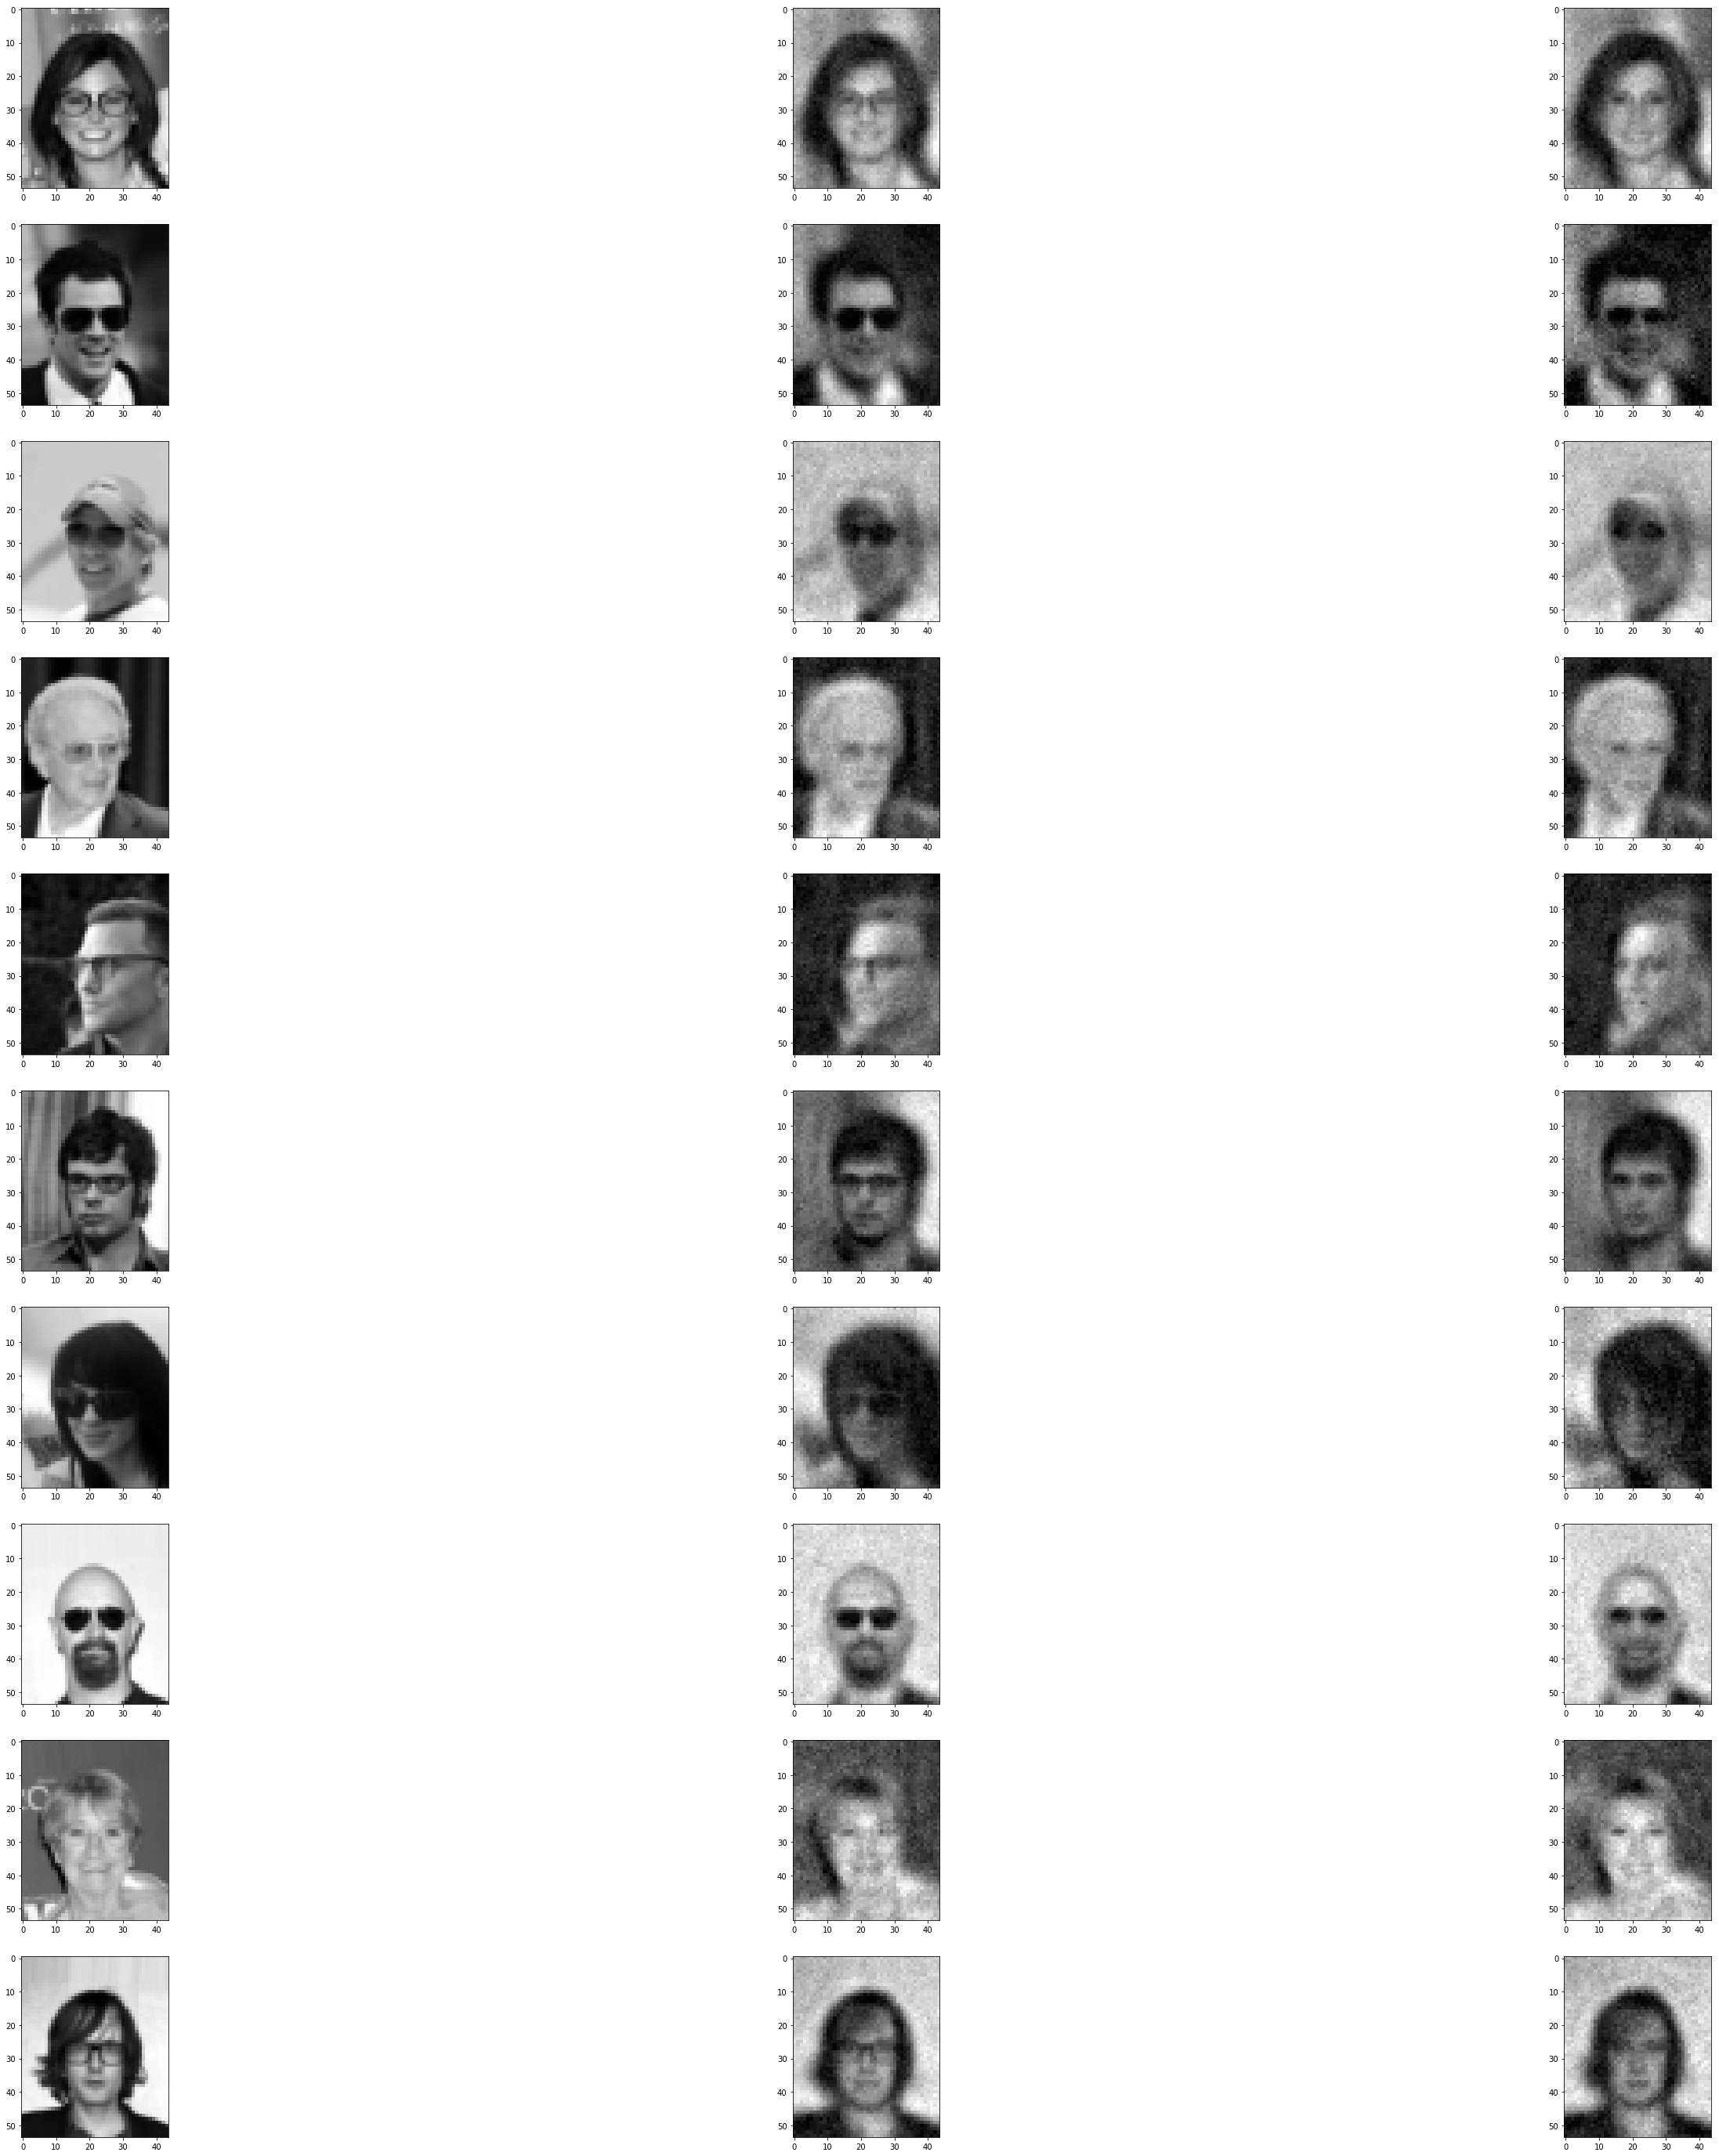

In [64]:
def faceData():
    hidden_layer_sizes = [500] #[500, 100, 40, 10]
    batch_sz = 64
    n_inputs=2376
    start=0
    lens=1000
    learning_rate=0.01
    
    ae_with_glasses =   CSE674AutoEncoder(n_inputs, hidden_layer_sizes)
    ae_no_glasses =   CSE674AutoEncoder(n_inputs, hidden_layer_sizes)
    losses_with_glasses = []
    losses_no_glasses = []
    epochs = 10
    
    #first with glasses
    celebs_with_glasses = np.asarray(celeb_glasses)
    batch_num  = 0
    num_batches= celebs_with_glasses.shape[0]// batch_sz

    for j in range(epochs):
        for i in range(num_batches):
            batch =  celebs_with_glasses[batch_sz*i: batch_sz*(i+1)]
            loss = ae_with_glasses.train_each_batch(batch)
            batch_num += 1
            losses_with_glasses.append(loss)
        print('epoch:', j)
    plt.plot(losses_with_glasses)
    print('Training celeb with glasses is done!')

    #Now with_out glasses
    celebs_with_no_glasses = np.asarray(celeb_no_glasses)
    batch_num  = 0
    num_batches= celebs_with_no_glasses.shape[0]// batch_sz

    epochs = 10

    for j in range(epochs):
        for i in range(num_batches):
            batch =  celebs_with_no_glasses[batch_sz*i: batch_sz*(i+1)]
            loss = ae_no_glasses.train_each_batch(batch)
            batch_num += 1
            losses_no_glasses.append(loss)
        print('epoch:', j)
    plt.plot(losses_no_glasses)
    print('Training celeb without glasses is also done!')    
    print('Training done!')
    
    visualizeTransferLearning(770)

if __name__ == '__main__':
    faceData()
    
    